# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [64]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',sep=';')


# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',sep=';')


In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

print(azdias.shape)

print(feat_info.shape)

azdias.head()
feat_info

(891221, 85)
(85, 4)


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [4]:
feat_info.describe()


,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,TITEL_KZ,person,ordinal,[-1]
freq,1,43,49,26


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [5]:
print('Number of naturally missing values is {}'.format(azdias.isnull().sum().sum()))


Number of naturally missing values is 4896838


In [6]:
for i in range(len(feat_info)):
    missing_val = feat_info.iloc[i]['missing_or_unknown']
    missing_val = missing_val.strip('[')
    missing_val = missing_val.strip(']')
    missing_val = missing_val.split(sep=',')
    missing_val = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in missing_val]
    if missing_val != ['']:
        azdias = azdias.replace({feat_info.iloc[i]['attribute']: missing_val}, np.nan)

In [7]:
final_missing_data = azdias.isnull().sum().sum()
print("Final Missing Data After mapping : {}".format(final_missing_data))

Final Missing Data After mapping : 8373929


In [8]:
azdias.isnull().sum().head()


AGER_TYP                685843
ALTERSKATEGORIE_GROB      2881
ANREDE_KZ                    0
CJT_GESAMTTYP             4854
FINANZ_MINIMALIST            0
dtype: int64

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

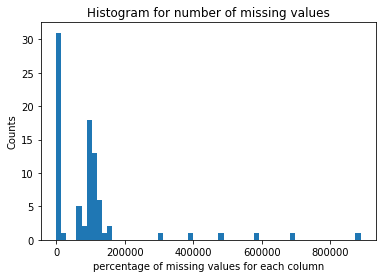

In [9]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
# Investigate patterns in the amount of missing data in each column.

missing_per_col =azdias.isnull().sum()


plt.hist(missing_per_col , bins=60)

plt.xlabel('percentage of missing values for each column')
plt.ylabel('Counts')
plt.title('Histogram for number of missing values')
plt.show()

In [10]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

cols = missing_per_col[missing_per_col>18].index
cols #list of outliers 
#n

Index(['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'CJT_GESAMTTYP', 'GEBURTSJAHR',
       'GFK_URLAUBERTYP', 'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN',
       'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB',
       'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ',
       'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S', 'SHOPPER_TYP', 'SOHO_KZ',
       'TITEL_KZ', 'VERS_TYP', 'ALTER_HH', 'ANZ_PERSONEN', 'ANZ_TITEL',
       'HH_EINKOMMEN_SCORE', 'KK_KUNDENTYP', 'W_KEIT_KIND_HH',
       'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP',
       'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE',
       'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015', 'KBA05_ANTG1',
       'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_BAUMAX',
       'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE', 'INNENSTADT', 'GEBAEUDETYP_RASTER',
       'KKK', 'MOBI_REGIO', 'ONLINE_AFFINITAET', 'REGIOTYP',
       'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3',
       'PLZ8_ANT

In [11]:
#remove outliers cols 
# engineering tasks such as re-encoding and imputation later.)

missing_more_30 =[]
for i in azdias.columns:
    if (azdias[i].isnull().sum()/azdias.shape[0]) * 100 > 30:
        missing_more_30.append(i)

missing_more_30

['AGER_TYP',
 'GEBURTSJAHR',
 'TITEL_KZ',
 'ALTER_HH',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX']

In [12]:
# Removing column with more than 30 percent missing data
azdias = azdias.drop(missing_more_30,axis=1)
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.1.2: Assess Missing Data in Each Column

Since most columns have less than 18% missing data, outlier columns are defined as those with at least 30% missing data so i droped them.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

(array([  6.23209000e+05,   1.57380000e+04,   2.79260000e+04,
          1.76290000e+04,   1.26070000e+04,   2.25150000e+04,
          1.37710000e+04,   1.37140000e+04,   2.45920000e+04,
          3.04200000e+03,   5.41000000e+03,   1.12700000e+03,
          7.66000000e+02,   3.25500000e+03,   2.24300000e+03,
          4.74300000e+03,   2.50500000e+03,   6.77000000e+02,
          4.28000000e+02,   1.18000000e+03,   3.49000000e+02,
          1.50000000e+02,   1.29000000e+02,   1.32000000e+02,
          6.90000000e+01,   5.50000000e+01,   5.90000000e+01,
          2.40000000e+01,   5.00000000e+00,   1.20000000e+01,
          6.00000000e+00,   3.00000000e+00,   2.06000000e+02,
          2.98500000e+03,   1.08160000e+04,   3.91100000e+03,
          8.40000000e+01,   5.38000000e+02,   4.21000000e+02,
          7.70000000e+01,   1.37000000e+02,   3.56000000e+02,
          2.10000000e+01,   2.73690000e+04,   1.55000000e+02,
          4.94000000e+02,   0.00000000e+00,   4.55780000e+04,
        

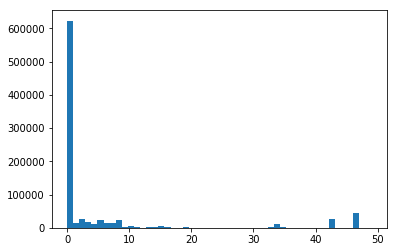

In [13]:
# How much data is missing in each row of the dataset?

check_missing_row_values = azdias.isnull().sum(axis=1)
plt.hist(check_missing_row_values , bins=50)
#n


In [14]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

missing_per_col_less_30=azdias[azdias.isnull().sum(axis=1)<30].reset_index(drop=True)
missing_per_col_above_30 = azdias[azdias.isnull().sum(axis=1) >= 30].reset_index(drop=True)


In [15]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

#  some columns with no missing columns values
c = ['ANREDE_KZ','SEMIO_DOM',  'SEMIO_RAT', 'SEMIO_TRADV', 'ZABEOTYP']
def compare(column):
    
    '''
    input: column name
    
    output: None
    '''
    fig = plt.figure(figsize=(14,4))
    ax1 = fig.add_subplot(121)
    ax1.title.set_text('Many missing rows')
    sns.countplot(azdias.loc[missing_per_col_above_30.index,column])

    ax2 = fig.add_subplot(122)
    ax2.title.set_text('Few missing rows')
    sns.countplot(azdias.loc[~azdias.index.isin(missing_per_col_less_30),column]);

    fig.suptitle(column)
    plt.show()


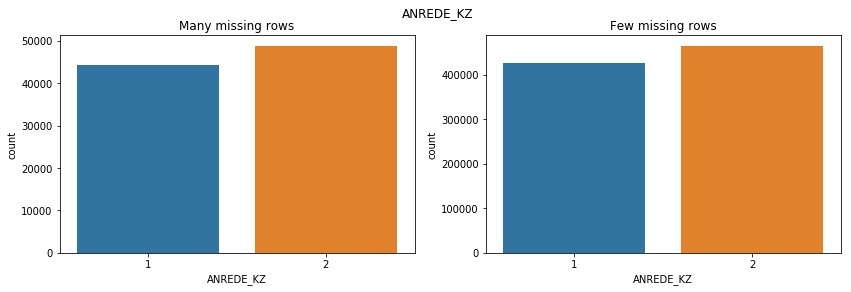

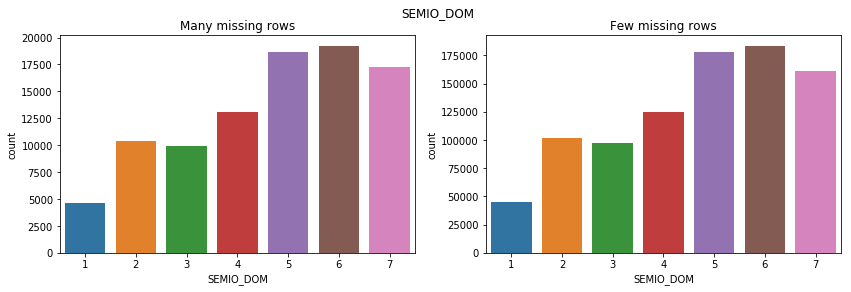

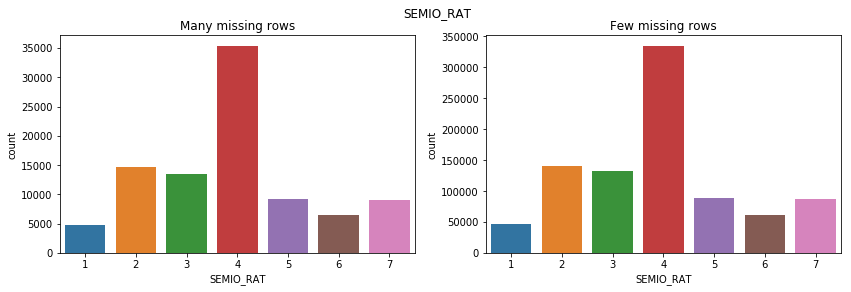

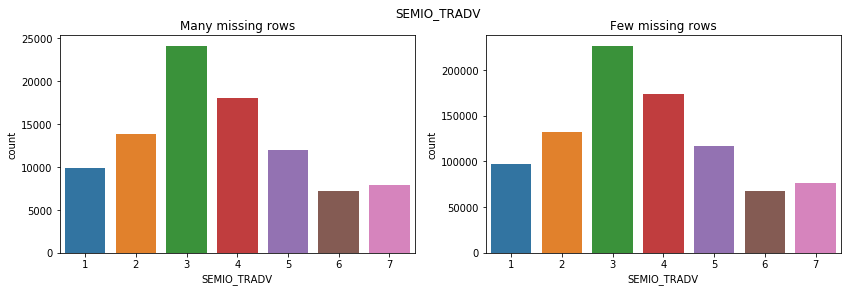

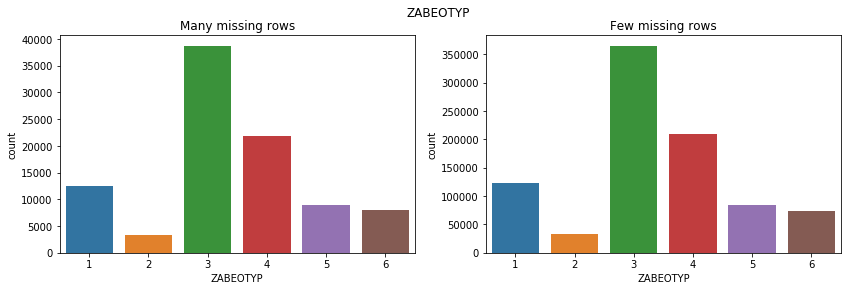

In [16]:
for i in c:
    compare(i)

In [17]:
# drop rows with high missing values Above 30 %
missing = azdias.iloc[missing_per_col_above_30.index]

azdias = azdias[~azdias.index.isin(missing_per_col_above_30.index)]


In [18]:
print(len(missing),"rows are greater than 30 % were dropped")


93160 rows are greater than 30 % were dropped


#### Discussion 1.1.3: Assess Missing Data in Each Row
Plotting the distributions of missing row values (low and high) showed that there was not a great difference between them, so I dropped these rows .



### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [19]:
# How many features are there of each data type
feat_info.groupby(['type'])['attribute'].count() 


type
categorical    21
interval        1
mixed           7
numeric         7
ordinal        49
Name: attribute, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [20]:
cat_variables=feat_info[feat_info['type'] == 'categorical']['attribute'].values
cat_variables 

array(['AGER_TYP', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP',
       'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN',
       'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',
       'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ',
       'VERS_TYP', 'ZABEOTYP', 'KK_KUNDENTYP', 'GEBAEUDETYP',
       'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015'], dtype=object)

In [21]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

categorical = [x for x in cat_variables if x in azdias.columns] # only the ones that are kept in azdias dataset
binary = [x for x in categorical if azdias[x].nunique()==2]
multilevel = [x for x in categorical if azdias[x].nunique()>2]
azdias[categorical].nunique()

ANREDE_KZ            2
CJT_GESAMTTYP        6
FINANZTYP            6
GFK_URLAUBERTYP     12
GREEN_AVANTGARDE     2
LP_FAMILIE_FEIN     11
LP_FAMILIE_GROB      5
LP_STATUS_FEIN      10
LP_STATUS_GROB       5
NATIONALITAET_KZ     3
SHOPPER_TYP          4
SOHO_KZ              2
VERS_TYP             2
ZABEOTYP             6
GEBAEUDETYP          7
OST_WEST_KZ          2
CAMEO_DEUG_2015      9
CAMEO_DEU_2015      44
dtype: int64

In [22]:
print(azdias[categorical].nunique().sum())
print(multilevel)
print('\n')
print(binary)

138
['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']


In [23]:
# Re-encode categorical variable(s) to be kept in the analysis.
col_binary = []
col_multi_vars = []

for i in categorical:
    if azdias[i].nunique() > 2:
        col_multi_vars.append(i)
    else:
        col_binary.append(i)

In [24]:
col_multi_vars


['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [25]:
col_binary


['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']

In [26]:
azdias['OST_WEST_KZ'].unique()

#drop multi_level + reencode OST_WEST_KZ to binary values 

azdias.drop(col_multi_vars, axis=1, inplace=True)

azdias.loc[:, 'OST_WEST_KZ'].replace({'W':'0', 'O':'1'}, inplace=True)


#### Discussion 1.2.1: Re-Encode Categorical Features

    1- Removed the multilevel categorical features
    2- Re-encoded the values in 'OST_WEST_KZ' as a binary values 0 & 1.



In [27]:
# checking unique values in categorical binary column
for col in col_binary:
    print(azdias[col].value_counts())

2    416483
1    381578
Name: ANREDE_KZ, dtype: int64
0    640911
1    157150
Name: GREEN_AVANTGARDE, dtype: int64
0.0    726425
1.0      6170
Name: SOHO_KZ, dtype: int64
2.0    356877
1.0    342022
Name: VERS_TYP, dtype: int64
0    562845
1    152061
Name: OST_WEST_KZ, dtype: int64


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [28]:
azdias[['PRAEGENDE_JUGENDJAHRE']].head()


,PRAEGENDE_JUGENDJAHRE
93160,3.0
93161,7.0
93162,8.0
93163,14.0
93164,14.0


In [29]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
def interval(x):
    if x in (1,2):
        return 1
    elif x in (3,4):
        return 2
    elif x in (5,6,7):
        return 3
    elif x in (8,9):
        return 4
    elif x in (10,11,12,13):
        return 5
    elif x in (14,15):
        return 6
    
def movment(x):
    if x in (2,4,6,7,9,11,13,15):
        return 0
    elif x in (1,3,5,8,10,12,14):
        return 1

In [30]:
# adding new columns "DECADES"  and 'MOVEMENTS' based on decade of birth and movement 
azdias['DECADES'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(interval)
azdias['MOVEMENTS'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(movment)

In [31]:
azdias['DECADES'].value_counts().sort_index()



1.0     25819
2.0     67891
3.0    104095
4.0    160580
5.0    135923
6.0    207280
Name: DECADES, dtype: int64

In [32]:
azdias['MOVEMENTS'].value_counts().sort_index()


0.0    157150
1.0    544438
Name: MOVEMENTS, dtype: int64

In [33]:
azdias = azdias.drop('PRAEGENDE_JUGENDJAHRE',axis=1)


In [34]:
# Adding a feature based on wealth
def wealth(x):
    if x // 10 ==1:
        return 1
    if x // 10 ==2:
        return 2
    if x // 10 ==3:
        return 3
    if x // 10 ==4:
        return 4
    if x // 10 ==5:
        return 5

# Adding a feature based on lfe stage
def life_stage(x):
    if x % 10 ==1:
        return 1
    if x % 10 ==2:
        return 2
    if x % 10 ==3:
        return 3
    if x % 10 ==4:
        return 4
    if x % 10 ==5:
        return 5

In [35]:
azdias['CAMEO_INTL_2015'] = pd.to_numeric(azdias['CAMEO_INTL_2015']) # convert to numerics



In [36]:
# add new columns 'WEALTH'  and 'LIFE_STAGE' 
azdias['WEALTH'] = azdias['CAMEO_INTL_2015'].apply(wealth)
azdias['LIFE_STAGE'] = azdias['CAMEO_INTL_2015'].apply(life_stage)

azdias.drop('CAMEO_INTL_2015', axis=1, inplace=True)

In [37]:
#azdias = azdias.drop(['CAMEO_DEUG_2015', 'CAMEO_DEU_2015'], axis=1)


### Discussion 1.2.2: Engineer Mixed-Type Features

**Adding new features based on interval , movment , wealth and life stage**

**adding new columns "DECADES"  and 'MOVEMENTS' based on decade of birth and movement using  `PRAEGENDE_JUGENDJAHRE` column**

**adding new columns "WEALTH"  and 'LIFE_STAGE' based on decade of birth and movement using  `CAMEO_INTL_2015` column**

  I decided to drop the PRAEGENDE_JUGENDJAHRE and  CAMEO_INTL_2015 columns and keep the new modified columns 

### Step 1.2.3: Complete Feature Selection
In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:


All numeric, interval, and ordinal type columns from the original dataset.

Binary categorical features (all numerically-encoded).

Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset.
Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from the subset with few or no missing values.

In [38]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
azdias.loc[:, azdias.dtypes == 'O']


,OST_WEST_KZ
93160,1
93161,1
93162,1
93163,1
93164,1
93165,1
93166,1
93167,0
93168,0
93169,0


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [39]:
def clean_data(df):
  
   
    # convert missing value codes into NaNs   
    for i,item in zip(range(len(df)), df.iteritems()):
        missing_unknown = feat_info['missing_or_unknown'][i]
        missing_unknown = missing_unknown[1:-1].split(',')
        column_name = item[0]
        if missing_unknown != ['']:
            miss = [x if x in ['X','XX'] else int(x) for x in missing_unknown]
            
            df[column_name] = df[column_name].replace(miss,np.nan)
            
    
    # remove rows having > 30% of missing values
    df = df.drop(['AGER_TYP','GEBURTSJAHR','TITEL_KZ','ALTER_HH','KK_KUNDENTYP','KBA05_BAUMAX'],axis=1)
    

    # removing selected rows 
    missing_row_values = df.isnull().sum(axis=1)
    missing_row_values.value_counts().sort_index(ascending=False,inplace=True)
    # dividing the rows into 2 subsets based on having missing value less than 30% or not<
    missing_per_col_less_30 = df[df.isnull().sum(axis=1)<30].reset_index(drop=True)
    missing_per_col_above_30 = df[df.isnull().sum(axis=1)>=30].reset_index(drop=True)
    
    
    # selecting rows with high missing values above 30 %
    df_missing_above_30 = df.iloc[missing_per_col_above_30.index]
    print("the shape of data set : ",df.shape[0])
    
  

    # dropping rows with high missing values
    df = df[~df.index.isin(missing_per_col_above_30.index)]
    print(len(df_missing_above_30),"row values were dropped")
    
    print(df.shape[0],"rows are remaining")
       
    
 
    # dropp the multilevel columns
    for i in df.columns:
        if i in col_multi_vars:
            df.drop(i, axis=1, inplace=True)
            
    
    # encoding the 'OST_WEST_KZ' binary categorical column
    df.loc[:, 'OST_WEST_KZ'].replace({'W':'0', 'O':'1'}, inplace=True) 
    
    # adding 2 new columns "DECADES" and 'MOVEMENTS' based on decade of birth and movement
    df['DECADES'] = df['PRAEGENDE_JUGENDJAHRE'].apply(interval)
    df['MOVEMENTS'] = df['PRAEGENDE_JUGENDJAHRE'].apply(movment)
    # Drop
    df = df.drop('PRAEGENDE_JUGENDJAHRE',axis=1)
     
    # Adding 2 new features based on wealth and life stage and dropping 'CAMEO_INTL_2015'
    df['CAMEO_INTL_2015'] = pd.to_numeric(df['CAMEO_INTL_2015']) #convert it to numric first 
    
    df['wealth'] = df['CAMEO_INTL_2015'].apply(wealth)
    df['life_stage'] = df['CAMEO_INTL_2015'].apply(life_stage)
    #drop
    df.drop('CAMEO_INTL_2015', axis=1, inplace=True)
    
    # a list of columns
    col_list = df.columns
       
    # impute NaN 
    imputer = Imputer(strategy='mean', axis=0)
    df = imputer.fit_transform(df)
    df = pd.DataFrame(df, columns=col_list)
    
    print('Done')

    # Return the cleaned dataframe.
    return df, df_missing_above_30

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [40]:
azdias_copy=azdias.copy()
col_list = azdias_copy.columns

In [41]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now
imputer = Imputer(strategy='mean', axis=0)
azdias_copy = imputer.fit_transform(azdias_copy)

In [46]:
#change it to df 
azdias_copy = pd.DataFrame(azdias_copy, columns= col_list)
print("the total null values : ",azdias_copy.isnull().sum())

the total null values :  ALTERSKATEGORIE_GROB     0
ANREDE_KZ                0
FINANZ_MINIMALIST        0
FINANZ_SPARER            0
FINANZ_VORSORGER         0
FINANZ_ANLEGER           0
FINANZ_UNAUFFAELLIGER    0
FINANZ_HAUSBAUER         0
GREEN_AVANTGARDE         0
HEALTH_TYP               0
LP_LEBENSPHASE_FEIN      0
LP_LEBENSPHASE_GROB      0
RETOURTYP_BK_S           0
SEMIO_SOZ                0
SEMIO_FAM                0
SEMIO_REL                0
SEMIO_MAT                0
SEMIO_VERT               0
SEMIO_LUST               0
SEMIO_ERL                0
SEMIO_KULT               0
SEMIO_RAT                0
SEMIO_KRIT               0
SEMIO_DOM                0
SEMIO_KAEM               0
SEMIO_PFLICHT            0
SEMIO_TRADV              0
SOHO_KZ                  0
VERS_TYP                 0
ANZ_PERSONEN             0
                        ..
OST_WEST_KZ              0
WOHNLAGE                 0
KBA05_ANTG1              0
KBA05_ANTG2              0
KBA05_ANTG3              0
KBA

In [47]:
azdias_copy.head() # scale this df 

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADES,MOVEMENTS,WEALTH,LIFE_STAGE
0,4.0,2.0,5.0,1.0,4.0,2.0,1.0,4.0,0.0,2.0,...,1.0,2.0,3.0,3.0,3.0,2.0,2.0,1.0,4.0,3.0
1,3.0,1.0,5.0,1.0,4.0,1.0,1.0,3.0,1.0,3.0,...,1.0,4.0,3.0,4.0,8.0,3.0,3.0,0.0,1.0,5.0
2,3.0,2.0,4.0,3.0,3.0,4.0,2.0,1.0,0.0,3.0,...,1.0,2.0,3.0,3.0,4.0,2.0,4.0,1.0,4.0,5.0
3,2.0,1.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,...,3.0,4.0,3.0,4.0,5.0,3.0,6.0,1.0,5.0,4.0
4,2.0,2.0,2.0,5.0,2.0,5.0,3.0,4.0,0.0,1.0,...,1.0,2.0,3.0,3.0,1.0,2.0,6.0,1.0,4.0,3.0


In [48]:
# Apply feature scaling to the general population demographics data.

scaler = StandardScaler()
azdias_scaled = scaler.fit_transform(azdias_copy)
azdias_scaled = pd.DataFrame(azdias_scaled, columns= col_list)
azdias_scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADES,MOVEMENTS,WEALTH,LIFE_STAGE
0,1.231412,0.957179,1.454051,-1.241620,0.453026,-0.675111,-1.259957,0.684390,-0.495175,-0.268112,...,-0.692964,-1.774003,-0.367319,-0.176995,-1.052862,-0.832891,-1.703722,0.573007,0.536028,0.089457
1,0.240123,-1.044737,1.454051,-1.241620,0.453026,-1.329063,-1.259957,-0.053970,2.019490,1.146826,...,-0.692964,0.427850,-0.367319,0.882833,1.245454,-0.054110,-0.973237,-1.985153,-1.636902,1.518387
2,0.240123,0.957179,0.697641,0.123572,-0.302845,0.632794,-0.587234,-1.530689,-0.495175,1.146826,...,-0.692964,-1.774003,-0.367319,-0.176995,-0.593198,-0.832891,-0.242752,0.573007,0.536028,1.518387
3,-0.751165,-1.044737,-1.571589,1.488764,-1.058716,1.286746,0.758211,1.422749,-0.495175,1.146826,...,0.777350,0.427850,-0.367319,0.882833,-0.133535,-0.054110,1.218218,0.573007,1.260338,0.803922
4,-0.751165,0.957179,-0.815179,1.488764,-1.058716,1.286746,0.085488,0.684390,-0.495175,-1.683050,...,-0.692964,-1.774003,-0.367319,-0.176995,-1.972188,-0.832891,1.218218,0.573007,0.536028,0.089457


### Discussion 2.1: Apply Feature Scaling

   Filling the missing values with the mean value, then scaled the dataframe



### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [54]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
pca = PCA()
pca_features = pca.fit_transform(azdias_scaled)
pd.DataFrame(pca_features)

,0,1,2,3,4,5,6,7,8,9,...,58,59,60,61,62,63,64,65,66,67
0,-2.716281,4.018037,-1.229286,-1.273035,1.130979,-1.911860,1.055151,-2.033615,0.150080,-0.284924,...,-0.048717,0.154625,0.024147,-0.606457,0.509026,0.160789,-0.245609,-0.046285,-0.036858,-0.063264
1,-2.343823,2.523602,2.390789,3.396658,0.246205,-2.516964,-0.797675,2.643363,0.419623,0.416563,...,0.108221,0.142738,0.072383,0.379256,0.012926,-0.081383,0.037494,-0.008261,0.102679,-0.045226
2,-4.019480,-0.518882,-2.586931,-0.271870,4.506427,-0.272411,0.518704,0.656837,2.722968,0.720818,...,0.757519,0.186379,0.486516,0.062268,0.515543,-0.863319,-0.509795,-0.014687,-0.179775,0.061795
3,4.700684,-3.227890,2.735160,-1.424048,-1.308201,-0.277221,-0.646931,-3.796312,1.037797,0.134992,...,0.570966,-0.436790,0.030360,-0.018855,0.157649,-0.519265,0.385761,-0.421629,-0.099936,-0.034612
4,-1.567080,-3.825102,-2.996074,-3.910897,1.003823,-2.481664,1.195094,-0.919058,-1.725008,1.594923,...,-0.008347,0.202462,0.216224,0.158713,-0.092966,-0.338523,-0.544308,-0.461174,-0.061521,-0.046521
5,-2.047517,-3.080323,-1.268782,0.141065,-2.198957,0.155258,0.390467,1.546259,1.172977,-0.175538,...,0.029728,-0.077593,-0.137608,-0.347167,0.599047,0.099800,0.438762,0.039684,0.011434,0.031196
6,-5.304838,1.327998,2.810126,-3.663068,1.059165,-3.056947,1.693797,-0.568502,-1.449218,0.495520,...,-0.164069,0.252956,0.172072,0.182997,-0.653357,0.008493,-0.188411,0.168580,0.037879,-0.073150
7,-4.274912,-5.767029,3.479092,-0.826641,2.875207,0.772808,0.326186,1.202526,-1.495456,0.098017,...,-0.149901,0.630215,0.289263,0.573619,0.330139,-0.262384,-0.775481,-0.371761,-0.104984,0.008074
8,-3.282746,0.927050,-1.555937,5.333094,1.180046,1.760881,-0.640667,-0.106114,1.351518,0.101847,...,0.860756,0.317954,-0.203203,-0.383207,-0.219915,0.300685,-0.436619,0.056099,-0.077689,-0.063275
9,-1.462939,1.921358,-1.579674,3.380121,0.154380,2.551864,-0.288582,-1.304324,1.122135,-0.932869,...,-0.039453,-0.089249,-0.377892,-0.219257,-0.156107,0.416183,-0.528536,0.281862,-0.156254,-0.004706


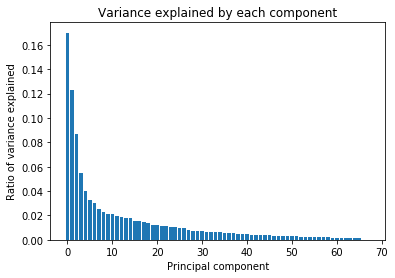

In [55]:
# Investigate the variance accounted for by each principal component.

plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
plt.title("Variance explained by each component")
plt.xlabel("Principal component")
plt.ylabel("Ratio of variance explained")
plt.show()

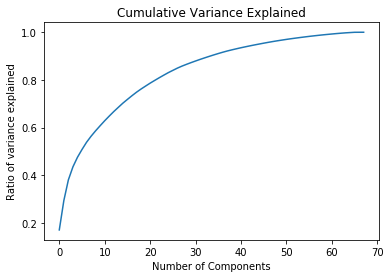

In [56]:
plt.plot(range(len(pca.explained_variance_ratio_)),np.cumsum(pca.explained_variance_ratio_), '-')
plt.title("Cumulative Variance Explained")
plt.xlabel("Number of Components")
plt.ylabel("Ratio of variance explained")
plt.show()

In [57]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca = PCA(30)
pca_features2 = pca.fit_transform(azdias_scaled)
pd.DataFrame(pca_features2)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,-2.716281,4.018038,-1.229287,-1.273049,1.131125,-1.911852,1.055094,-2.032455,0.148853,-0.284606,...,0.470107,1.696804,0.809095,0.681224,-0.478326,-1.764139,-0.151721,0.250231,-1.284183,0.485226
1,-2.343822,2.523602,2.390787,3.396649,0.246169,-2.516972,-0.797743,2.643298,0.418941,0.417246,...,-0.618048,1.104341,0.602087,-0.490477,0.032928,0.222196,0.657364,0.444611,-0.228020,-0.113557
2,-4.019480,-0.518885,-2.586927,-0.271838,4.506258,-0.272604,0.518687,0.655157,2.725662,0.720721,...,-0.376696,-1.097693,-0.915766,0.161172,-1.285080,0.469658,1.192700,-0.910126,-0.493558,-0.382518
3,4.700684,-3.227890,2.735162,-1.424056,-1.308145,-0.277180,-0.646940,-3.795913,1.038204,0.134697,...,-1.025028,-0.341281,-0.847041,-1.010966,-1.823305,0.374394,-0.031467,1.416049,-0.478137,0.608460
4,-1.567080,-3.825105,-2.996087,-3.910879,1.003911,-2.481944,1.195035,-0.919768,-1.724095,1.596265,...,-0.474168,-0.496888,-0.191273,0.089035,-0.546562,0.824989,-1.278122,-0.782003,0.104596,-0.129384
5,-2.047517,-3.080323,-1.268777,0.141046,-2.199036,0.154963,0.390263,1.545523,1.175569,-0.174515,...,-0.484878,-0.111069,0.734940,1.087937,-1.484605,0.583675,-0.455070,0.634639,-0.117587,-0.325552
6,-5.304839,1.328000,2.810133,-3.663075,1.059100,-3.056757,1.693821,-0.568011,-1.450502,0.494449,...,0.267508,0.524562,0.230965,1.057592,0.822238,-0.238842,0.190224,-0.245564,0.588019,0.076894
7,-4.274912,-5.767029,3.479089,-0.826680,2.875232,0.772883,0.326159,1.202840,-1.496596,0.098844,...,0.027582,0.336442,-0.061890,-0.243592,1.217281,-0.236305,0.189841,0.177945,-0.339574,0.786103
8,-3.282746,0.927051,-1.555930,5.333093,1.179925,1.760936,-0.640638,-0.106851,1.351657,0.101433,...,-0.539871,0.014791,0.261179,-0.829537,0.634402,-0.117147,-0.290654,-0.145208,0.885449,0.892414
9,-1.462938,1.921357,-1.579677,3.380144,0.154438,2.551896,-0.288468,-1.304157,1.122545,-0.933473,...,-1.278546,-0.894046,0.091138,-1.715616,0.341084,1.184952,0.808503,0.002865,0.391713,-0.748531


### Discussion 2.2: Perform Dimensionality Reduction

retain 30 principal components, as it expalains more than 88% variances ,in this way i avoid unnecessary data or features.



### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [58]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def pca_weights(pca, i):
    df = pd.DataFrame(pca.components_, columns=list(azdias_scaled.columns))
    weights = df.iloc[i].sort_values(ascending=False)
    return weights

In [59]:
weights_pc0 = pca_weights(pca, 0)
weights_pc0

PLZ8_ANTG3               0.228505
PLZ8_ANTG4               0.222736
PLZ8_BAUMAX              0.218057
WEALTH                   0.203002
ORTSGR_KLS9              0.201236
EWDICHTE                 0.198983
HH_EINKOMMEN_SCORE       0.174757
FINANZ_HAUSBAUER         0.163472
PLZ8_ANTG2               0.154560
KBA05_ANTG4              0.153062
ARBEIT                   0.144193
RELAT_AB                 0.135827
ANZ_HAUSHALTE_AKTIV      0.135811
KBA05_ANTG3              0.132165
FINANZ_SPARER            0.108829
MOVEMENTS                0.098680
SEMIO_PFLICHT            0.081779
SEMIO_REL                0.074633
REGIOTYP                 0.067759
SEMIO_RAT                0.066771
DECADES                  0.065974
W_KEIT_KIND_HH           0.058391
SEMIO_MAT                0.056561
SEMIO_FAM                0.055853
SEMIO_TRADV              0.055675
OST_WEST_KZ              0.055137
SEMIO_KAEM               0.046657
SEMIO_KULT               0.043547
FINANZ_UNAUFFAELLIGER    0.043262
PLZ8_HHZ      

In [60]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

weights_pc0 = pca_weights(pca, 1)
weights_pc0

ALTERSKATEGORIE_GROB     0.279001
FINANZ_VORSORGER         0.258796
SEMIO_ERL                0.228343
SEMIO_LUST               0.190192
RETOURTYP_BK_S           0.172327
W_KEIT_KIND_HH           0.123029
FINANZ_MINIMALIST        0.111404
FINANZ_HAUSBAUER         0.090193
WOHNDAUER_2008           0.070304
EWDICHTE                 0.065793
ORTSGR_KLS9              0.064654
PLZ8_ANTG3               0.061683
SEMIO_KRIT               0.059800
PLZ8_ANTG4               0.058822
SEMIO_KAEM               0.055431
PLZ8_BAUMAX              0.054469
ANREDE_KZ                0.051932
ARBEIT                   0.048296
RELAT_AB                 0.046473
KBA05_ANTG4              0.046090
HH_EINKOMMEN_SCORE       0.045022
WEALTH                   0.044143
ANZ_HAUSHALTE_AKTIV      0.043199
PLZ8_ANTG2               0.042513
VERS_TYP                 0.030985
ANZ_HH_TITEL             0.026515
SEMIO_DOM                0.025472
KBA05_ANTG3              0.022325
LIFE_STAGE               0.020202
OST_WEST_KZ   

In [61]:
pca_weight_2= pca_weights(pca, 2)
pca_weight_2

SEMIO_VERT               0.354086
SEMIO_SOZ                0.290411
SEMIO_KULT               0.282272
SEMIO_FAM                0.238139
FINANZ_MINIMALIST        0.138380
RETOURTYP_BK_S           0.078550
SEMIO_MAT                0.068677
FINANZ_VORSORGER         0.063930
W_KEIT_KIND_HH           0.063299
GREEN_AVANTGARDE         0.062240
SEMIO_REL                0.060413
ALTERSKATEGORIE_GROB     0.040162
PLZ8_BAUMAX              0.035448
PLZ8_ANTG4               0.032268
ORTSGR_KLS9              0.031814
PLZ8_ANTG3               0.030740
EWDICHTE                 0.030058
ARBEIT                   0.024320
RELAT_AB                 0.021150
WOHNDAUER_2008           0.020418
PLZ8_ANTG2               0.019595
HH_EINKOMMEN_SCORE       0.019266
SEMIO_LUST               0.017425
WEALTH                   0.016790
KBA05_ANTG4              0.015867
ANZ_HAUSHALTE_AKTIV      0.015155
OST_WEST_KZ              0.012667
ANZ_TITEL                0.007922
ANZ_HH_TITEL             0.007363
LP_LEBENSPHASE

### Discussion 2.3: Interpret Principal Components

From the first principal component, it can be seen that
**A positive value means that feature is directly related to that principal component**


   `PLZ8_ANTG3               0.228505`
   
   `PLZ8_ANTG4               0.222736`
   
   `PLZ8_BAUMAX              0.218057`
   
   `WEALTH                   0.203002`

    
    As these are the most positive correlations in the first principal component, so in PLZ8 regions the share of family
    homes is a very important feature, also wealth has a strong relation with PLZ8 regions, meaning poor households arise 
    more as the share of family homes increases.
    
   ` MOBI_REGIO              -0.239065 `


    the most negitive correlations in the first principal component ,MOBI_REGIO and PLZ8_ANTG3 . It means when the share of family homes increases the more higher movements.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [62]:
def k_mean_score(data, n_cluster):
    kmeans = KMeans(n_clusters = n_cluster)
    model = kmeans.fit(data)
    score = np.abs(model.score(data))
    return score

In [65]:
scores = []
ks = list(range(1,20))
for k in ks:
    scores.append(k_mean_score(pca_features2, k)) #too long  # 30 - 20 min 

Text(0,0.5,'SSE')

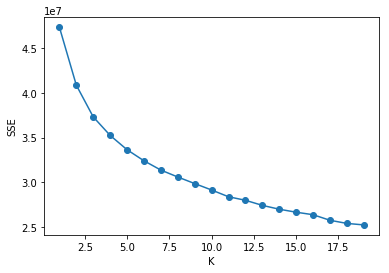

In [66]:
plt.plot(ks, scores, linestyle='-', marker='o')
plt.xlabel('K')
plt.ylabel('SSE')

In [67]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(n_clusters = 16)
model_16 = kmeans.fit(pca_features2)
azdias_pred = model_16.predict(pca_features2) #too long too 10  min 

### Discussion 3.1: Apply Clustering to General Population

It appears that K=16 is the elbow based on the above plot.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [68]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')


In [69]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_clean, customer_many_missing  = clean_data(customers)


the shape of data set :  191652
49927 row values were dropped
141725 rows are remaining
Done


In [70]:
customers_clean.head()


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADES,MOVEMENTS,wealth,life_stage
0,1.0,2.0,2.0,5.0,3.0,5.0,5.0,3.0,0.0,1.953821,...,1.000000,4.000000,4.000000,4.000000,7.000000,5.000000,2.884249,0.507327,1.00000,3.00000
1,3.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,0.0,1.953821,...,1.554663,3.636646,3.624227,2.823007,5.117355,2.896732,2.884249,0.507327,2.59701,3.36958
2,4.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,0.0,2.000000,...,1.000000,4.000000,5.000000,4.000000,3.000000,5.000000,1.000000,1.000000,1.00000,5.00000
3,4.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,1.0,1.000000,...,1.000000,4.000000,4.000000,3.000000,6.000000,2.000000,2.000000,0.000000,1.00000,5.00000
4,4.0,2.0,2.0,1.0,5.0,1.0,1.0,5.0,0.0,1.000000,...,4.000000,3.000000,2.000000,3.000000,7.000000,5.000000,3.000000,1.000000,3.00000,1.00000


In [71]:
len(customers_clean)

141725

In [72]:
#Scaler

standardized_customers = scaler.transform(customers_clean)
#PCA
pca_customers = pca.transform(standardized_customers)
#Predict using Kmeans model
predict_customers = model_16.predict(pca_customers)

In [74]:
predict_customers


array([6, 6, 9, ..., 7, 2, 9], dtype=int32)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

Text(0.5,1,'General Clusters')

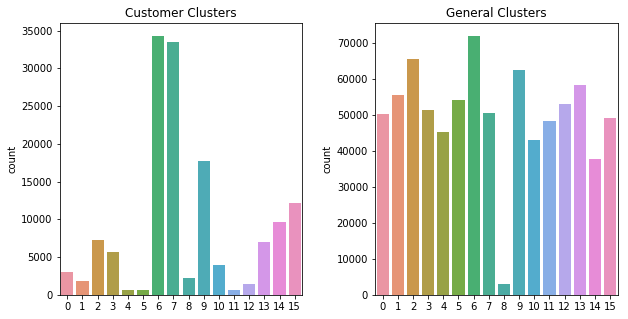

In [91]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.


figure, axs = plt.subplots(nrows=1, ncols=2, figsize = (10,5))
figure.subplots_adjust(hspace = 1, wspace=.3)

sns.countplot(predict_customers, ax=axs[0])
axs[0].set_title('Customer Clusters')
sns.countplot(azdias_pred, ax=axs[1])
axs[1].set_title('General Clusters')

In [102]:
counts_cluster_gen = pd.Series(azdias_pred).value_counts().sort_index()
counts_cluster_gen.index = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]

prop_cluster_gen = []
for value in counts_cluster_gen:
    prop = value / len(azdias_pred)
    prop_cluster_gen.append(prop)

prop_cluster_general = pd.Series(prop_cluster_gen)
prop_cluster_general.index = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]


counts_cluster_cust = pd.Series(predict_customers).value_counts().sort_index()
counts_cluster_cust.index = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]

prop_cluster_cust = []
for value in counts_cluster_cust:
    prop = value / len(predict_customers)
    prop_cluster_cust.append(prop)

prop_cluster_customers = pd.Series(prop_cluster_cust)
prop_cluster_customers.index = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]

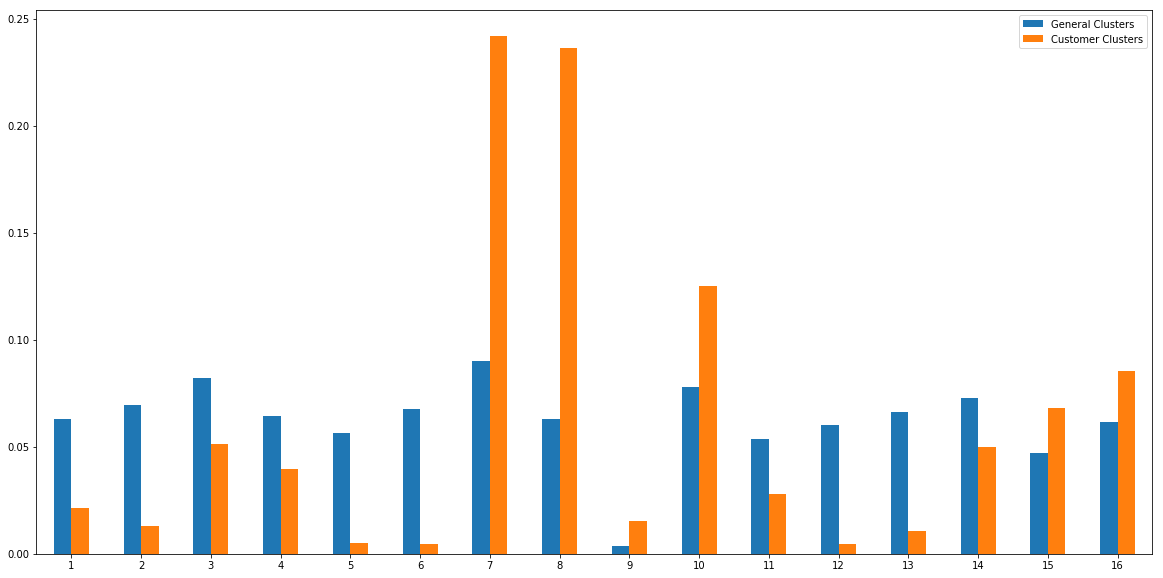

In [109]:
prop = pd.DataFrame({'General Clusters': prop_cluster_general,
                     'Customer Clusters': prop_cluster_customers})

ax = prop.plot.bar(rot=0, figsize=(20, 10))

In [86]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

#7 is overrepresented 

centroid = scaler.inverse_transform(pca.inverse_transform(model_16.cluster_centers_[7]))


In [105]:
overrepresented= pd.Series(data = centroid, index = customers_clean.columns)
overrepresented

ALTERSKATEGORIE_GROB       2.354586
ANREDE_KZ                  1.578984
FINANZ_MINIMALIST          2.923493
FINANZ_SPARER              4.065174
FINANZ_VORSORGER           2.909496
FINANZ_ANLEGER             4.969786
FINANZ_UNAUFFAELLIGER      4.918108
FINANZ_HAUSBAUER           3.000641
GREEN_AVANTGARDE           0.014921
HEALTH_TYP                 2.188423
LP_LEBENSPHASE_FEIN       17.336916
LP_LEBENSPHASE_GROB        5.264178
RETOURTYP_BK_S             3.304998
SEMIO_SOZ                  1.798025
SEMIO_FAM                  5.804449
SEMIO_REL                  6.840755
SEMIO_MAT                  4.914788
SEMIO_VERT                 1.221495
SEMIO_LUST                 5.123262
SEMIO_ERL                  3.098932
SEMIO_KULT                 3.141379
SEMIO_RAT                  4.043924
SEMIO_KRIT                 6.992451
SEMIO_DOM                  5.862014
SEMIO_KAEM                 5.740721
SEMIO_PFLICHT              5.174947
SEMIO_TRADV                2.959401
SOHO_KZ                    0

In [110]:
#12 is under rep
centroid_12 = scaler.inverse_transform(pca.inverse_transform(model_16.cluster_centers_[12]))


In [111]:
underrepresented= pd.Series(data = centroid_12, index = customers_clean.columns)


In [112]:
underrepresented


ALTERSKATEGORIE_GROB       1.758107
ANREDE_KZ                  1.967182
FINANZ_MINIMALIST          2.694260
FINANZ_SPARER              3.837764
FINANZ_VORSORGER           2.275424
FINANZ_ANLEGER             4.377555
FINANZ_UNAUFFAELLIGER      3.867846
FINANZ_HAUSBAUER           2.365049
GREEN_AVANTGARDE           0.230626
HEALTH_TYP                 2.226559
LP_LEBENSPHASE_FEIN       21.309433
LP_LEBENSPHASE_GROB        6.487578
RETOURTYP_BK_S             2.509164
SEMIO_SOZ                  3.090422
SEMIO_FAM                  3.737001
SEMIO_REL                  5.154378
SEMIO_MAT                  5.101229
SEMIO_VERT                 2.718229
SEMIO_LUST                 3.086296
SEMIO_ERL                  4.471204
SEMIO_KULT                 4.007250
SEMIO_RAT                  6.187003
SEMIO_KRIT                 5.416232
SEMIO_DOM                  5.895610
SEMIO_KAEM                 5.638427
SEMIO_PFLICHT              5.974093
SEMIO_TRADV                5.810156
SOHO_KZ                    0

### Discussion 3.3: Compare Customer Data to Demographics Data

Compared to general population data, `Cluster 7` is overrepresented in the customers data:

    PLZ8_ANTG3= 1.593100

    WEALTH= 3.177817

    LIFE_STAGE= 2.849517

Customers in `Cluster 13` are under represented ,Some characteristics of this segment of the population that are generally unpopular:

    PLZ8_ANTG3=0.844720

    WEALTH= 2.270514
    
    LIFE_STAGE= 3.302700


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.